# Part 4: Predictive Modelling, Coding, & Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pybaseball
import sklearn.naive_bayes as nb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.ensemble
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingRegressor

In [3]:
## data = pybaseball.statcast('2021-04-01', '2021-10-03') # using pybaseball to gather statcast data
## data.to_csv('2021_statcast.csv') # create csv
pd.set_option("display.max_columns", None)
data = pd.read_csv('Data/2021_statcast.csv')
# Nulls on pitch type caused issues, changed to "Undefined"
data['pitch_type'] = data.pitch_type.apply(lambda x : 'Undefined' if pd.isnull(x) else x)
# Added count variable for foltynewicz visaulization in tableau
data['Count'] = data[['balls', 'strikes']].apply(lambda x: f"{str(x.balls)} - {str(x.strikes)}", axis = 1)
folty = data[data['player_name'] == 'Foltynewicz, Mike'].groupby(['Count', 'pitch_type'])[['pitch_type']].count()
# folty.to_csv('Data/folty.csv')

# Read in fangraphs data, rearrange names to match statcast
year_stats = pd.read_csv('Data/fangraphs_2021.csv')
year_stats.Name = year_stats.Name.apply(lambda x : f"{x.replace(' ', ',').split(',')[1]}, {x.replace(' ', ',').split(',')[0]}")

**Question: Define pitcher “deception” and use publicly available data to create a leaderboard of the most deceptive MLB pitchers according to your definition.**

Per Meriam-Webster, *deception* is defined as:
> the act of causing someone to accept as true or valid what is false or invalid

There are a ton of ways that pitchers can accomplish this: hiding the ball well, varying armslot, velocity, timing, tunneling etc. Surely every pitcher, batter, and coach in the league has their own definition of what deception means.

Preliminarily, I would almost call deception and unpredictability synonymous. We'll start by focusing on capturing unpredictability in two ways through some feature engineering on Statcast's 2021 data (filtered to exclude pitchers with < 50 IP), and after a brief discussion on their shortcomings, I'll discuss the motivation behind adding more features to the dataset.

## Outcome: Called Strike/Whiff Rate

Until we start putting EEG caps into batting helmets, it's hard to be able to determine whether a batter was actually fooled. **CSW%** *might* be the best metric we have that can capture how often a pitcher fools a batter, although it is imperfect. We can see below that CSW% does have a very linear relationship with tERA:

![tera_csw-3.png](Images/tera_csw.png)


There are however some obvious flaws in this decision. For one, some pitchers induce a lot of soft contact and are still successful *without* elite CSW% (Mark Melancon, Logan Webb come to mind). Yet, these pitchers can still be deceptive in unconventional ways, and, more importantly *effective* pitchers. So, I will begrudgingly use CSW as the outcome variable of interest in this dataset, making this a regression problem. Let's begin by adding some derivable features from Statcast.

### Feature Engineering Unpredictability
If a machine can't guess what's coming, what hope is there for a human?

We'll model the human ability to predict pitches using two separate models: one will predict pitch type based on release point (release_posx, y, and z from Statcast), and another will predict pitch type based on the count. Surely there are other, better means for predicting a pitch type, but I'll keep this simple as these are two things a batter can conceivably pick up on in the moment. The logic to using machine learning methods to create these metrics is that presumably, if an algorithm deems a pitcher as difficult to predict, then surely humans would also have a hard time picking up on their patterns.

**Disclaimer:** This will inherently favor pitchers who try to make all their pitches look the same from a delivery standpoint, as well as those who sequence their pitches uniformly regardless of the count. Pattern finding is inherent to us, and the harder it is to find patterns in a pitcher, the more *deceptive* a pitcher is in my opinion.

With these two models deployed to create new features, I will subtract 1 from their respective weighted mean F1 scores. Thus, a pitcher with a higher "unpredictability" score would be one that the models could not predict well at all (i.e. a low weighted mean F1 score). Note: Accuracy wouldn't be great here due to many pitchers frequently throwing one pitch type, so I opted for a weighted mean F1 to avoid overrating pitchers who have a significant imbalance. So, for each, the score appended to the data will look like so:
> $Unpredictability = 1 - \textrm{weighted mean F1}$

#### Unpredictability by Release Point

We're not exactly looking for the *best* algorithm here–we simply need a way to compare pitchers' predictability, so there will not be much model tuning done. I opted for a Support Vector Machines Classifier to predict pitch type given release point, though I don't normally blindly pick an algorithm for such tasks. We're also not trying to deploy these models to predict future pitches for now, so there will be no partitioning for training/validation/testing. Again, I'm merely looking for a way to compare pitchers' predictability. The only parameter that isn't default here is:
```
class_weight = 'balanced'
```
Once again, this is to account for pitchers who have less variance in their pitch selection/arsenal. More info on that [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [236]:
unpredictability_svm = [] # list of player names and their unpredictability scores
# Iterate through each player in year_stats. This filters all pitchers with < 50 innings pitched.
for player in year_stats.Name.unique():
    df = data[data['player_name'] == player][['release_pos_x', 'release_pos_y',
                                              'release_pos_z', 'pitch_type']].dropna() # drop nulls
    # Assign predictors to X
    X = df[['release_pos_x', 'release_pos_y', 'release_pos_z']]
    # Target variable
    y = df.pitch_type

    # SVM generally performs significantly better scaled. Pipe scaled data into SVC.
    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", SVC(class_weight = 'balanced')),
    ])
    try:
        svm_clf.fit(X,y) # fit to data
        preds = svm_clf.predict(X) # make predictions
        score = f1_score(y, preds, average = 'weighted') # Get F1 score
        unpredictability_svm.append((player, 1 - score)) # Unpredictability by release = 1 - F1
    except:
        # Skip players who have insufficient data
        continue

#### Top 10 by Unpredictability by Release Point

In [571]:
pd.DataFrame(unpredictability_svm, columns = ['Player', 'unpredictability_by_release_point']
            ).sort_values('unpredictability_by_release_point', ascending = False).head(10)

,Player,unpredictability_by_release_point
60,"Stroman, Marcus",0.733032
134,"Gibson, Kyle",0.726567
293,"Kremer, Dean",0.701176
146,"Kluber, Corey",0.685260
30,"Woodruff, Brandon",0.679710
168,"Kaprielian, James",0.671325
272,"Happ, J.A.",0.669961
209,"Dunning, Dane",0.668897
193,"Taillon, Jameson",0.665989
263,"Foltynewicz, Mike",0.658583


These are certainly some good names to be around, though a mixed bag. Onward to unpredictability by count:

#### Unpredictability by Count
For this measure of unpredictability, I opted for a Multinomial Naive Bayes classifier. The motivation behind the choice is the same as above: we simply need a way to compare predictability, though the nature of Bayes' theorem may lend well to describing a pitcher's preferences by count, if any. 

In [ ]:
unpredictability_count = []
# Iterate only through players processed by SVM model above
for player in [i[0] for i in unpredictability_svm]:
    count_df = data[data['player_name'] == player][['pitch_type', 'balls', 'strikes']].dropna() # drop nulls
    snb = nb.MultinomialNB()
    snb.fit(count_df[['balls', 'strikes']], count_df.pitch_type) # Fit to X, y
    preds = snb.predict(count_df[['balls', 'strikes']]) # Create preds
    score = f1_score(count_df.pitch_type, preds, average = 'weighted') # Score
    unpredictability_count.append((player, 1 - score)) # Append player name and F1

#### Top 10 Unpredictable Pitchers by Count

In [573]:
pd.DataFrame(unpredictability_count, columns = ['Player', 'unpredictability_by_count']
            ).sort_values('unpredictability_by_count', ascending = False).head(10)

,Player,unpredictability_by_count
263,"Foltynewicz, Mike",0.866543
227,"Lester, Jon",0.852510
75,"Musgrove, Joe",0.848772
204,"Kelly, Merrill",0.842381
149,"Civale, Aaron",0.833508
64,"Wainwright, Adam",0.830090
179,"Gray, Sonny",0.827764
134,"Gibson, Kyle",0.827321
283,"Harvey, Matt",0.827018
129,"Sandoval, Patrick",0.826425


![folty.png](Images/folty.png)

We can see that Mike Foltynewicz does indeed mix his pitches fairly uniformly, save for 3-0 being almost exclusively fastballs (though not unusual). The rest of the names on the list are certainly familiar, though another mixed bag in terms of performance.

This is *far* from our final list and not to be taken seriously, but for fun let's take a peak and see who *would* be leading unpredictability thus far by the product of the two metrics:

In [617]:
temp_df = pd.DataFrame({'Player': [i[0] for i in unpredictability_svm],
                        'unpredictability_release' : [i[1] for i in unpredictability_svm],
                        'unpredictability_count' : [i[1] for i in unpredictability_count]})
# Multiply the two metrics created to give a (stupid) rudimentary leaderboard thus far
temp_df['product'] = temp_df['unpredictability_release'] * temp_df['unpredictability_count']
temp_df.sort_values('product', ascending = False).head(10).reset_index().drop(columns = ['index'])

,Player,unpredictability_release,unpredictability_count,product
0,"Gibson, Kyle",0.726567,0.827321,0.601104
1,"Foltynewicz, Mike",0.658583,0.866543,0.570690
2,"Kluber, Corey",0.685260,0.776676,0.532225
3,"Alcantara, Sandy",0.646386,0.797239,0.515325
4,"Stroman, Marcus",0.733032,0.702589,0.515020
5,"Thompson, Zach",0.626660,0.817686,0.512411
6,"Woodruff, Brandon",0.679710,0.751302,0.510668
7,"Musgrove, Joe",0.600915,0.848772,0.510039
8,"Civale, Aaron",0.605128,0.833508,0.504380
9,"Harvey, Matt",0.602269,0.827018,0.498087


Mostly above average guys; far from a complete picture.

### Adding More Predictors
Unfortunately, these are compromises and don't paint the whole picture. Any of those guys on that list could very well be tipping their pitches in other ways, though it's difficult to capture that with the data available.

Ideally, we'd have predictors that include other delivery attributes, like deviations in windup time (e.g. quick pitching, hitches) or how well hidden the ball is (Kershaw comes to mind). And how could we possibly quantify Johnny Cueto?! There are few things in baseball that I love more than a Johnny Cueto shimmy, but Statcast doesn't have its priorities right.

Also, this will not account for pitchers like Rich Hill, who intentionally changes his release point dramatically. Let's have a short Rich Hill-flavored anecdote to highlight how deception (or perceived deception) means different things to different pitchers.

#### Rich Hill's Release Point

<AxesSubplot:xlabel='release_pos_x', ylabel='release_pos_z'>

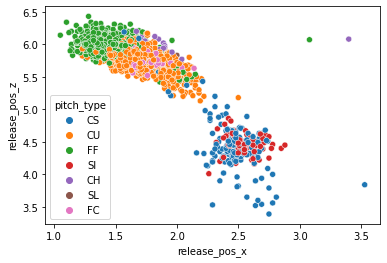

In [157]:
rich_hill = data[data['player_name'] == 'Hill, Rich'][[
    'pitch_type','release_pos_x', 'release_pos_y',
    'release_pos_z', 'estimated_woba_using_speedangle']]
sns.scatterplot(x = 'release_pos_x', y = 'release_pos_z',
                hue = 'pitch_type', data = rich_hill)

As we can see above, Rich Hill's pitch type is *very* predictable based on his release point. To contrast, let's look at a relatively consistent release point like Brandon Woodruff:

<AxesSubplot:xlabel='release_pos_x', ylabel='release_pos_z'>

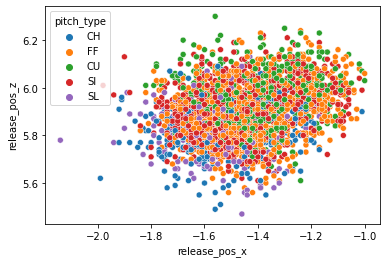

In [421]:
brandon_woodruff = data[data['player_name'] == 'Woodruff, Brandon'][
    ['pitch_type','release_pos_x', 'release_pos_y',
     'release_pos_z', 'estimated_woba_using_speedangle']]
sns.scatterplot(x = 'release_pos_x', y = 'release_pos_z',
                hue = 'pitch_type', data = brandon_woodruff)

By my chosen definition unpredictability, Brandon Woodruff is the more deceptive pitcher here. Is this *necessarily* true? I can't say for sure. At the very least, let's superficially have a look at the effectiveness of Rich Hill's deception by clustering his release points, and then showing their relationship with xwOBA (expected weighted on-base average):

<ipython-input-178-663263fc2e34>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  woba_clustering['cluster'] = preds


<AxesSubplot:xlabel='release_pos_x', ylabel='release_pos_z'>

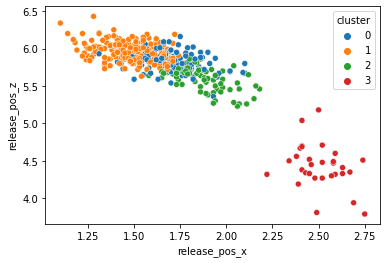

In [178]:
woba_clustering = rich_hill[rich_hill['estimated_woba_using_speedangle'].notnull()]
km = KMeans(n_clusters = 4)
preds = km.fit_predict(woba_clustering[['release_pos_x', 'release_pos_y', 'release_pos_z']])
woba_clustering['cluster'] = preds
sns.scatterplot(x = 'release_pos_x', y = 'release_pos_z', hue = 'cluster', palette = 'tab10', data = woba_clustering)

<AxesSubplot:xlabel='cluster', ylabel='estimated_woba_using_speedangle'>

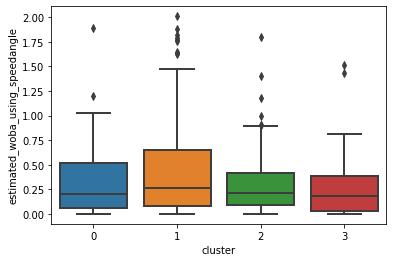

In [188]:
# Rich Hill xwOBA by Cluster
sns.boxplot(x = 'cluster', y = 'estimated_woba_using_speedangle', linewidth=2.0, data = woba_clustering)

It turns out Rich Hill's drop-angled pitches (cluster "3") have his *lowest* xwOBA at .29, so at the very least I'd categorize his deception as effective. Whether or not he's more "deceptive" than Brandon Woodruff is difficult to say. Let's look into how we can capture deception via deviance, i.e. "giving guys different looks".

#### Accounting for Deviation
What is more deceptive? Unpredictability in consistency, or deviation? Inspired partially by Rich Hill and the fact that the Dodgers just got demolished by Logan Webb, who also tends to drop his arm angle, I figured factoring for deviation/variance warrants inclusion to contrast favoring consistency thus far.
Additionally, Dodgers broadcaster and former pitcher Orel Hershiser often speaks about "giving guys different looks"  being very important for pitchers. According to him, this includes "changing eye levels" (i.e. mixing North/South, East/West sides of the plate) and changing speeds, among other things.

To capture these attributes, I'll take the standard deviation for release point coordinates, release speed, and how much a pitcher spreads the zone via coordinates as the ball passes the plate. This will let us see see what effect deviance has in determining CSW% and by proxy deception, if any.

In [ ]:
std_df = data[data['player_name'].isin(year_stats.Name.unique())][
    ['player_name', 'release_speed', 'release_pos_x', 'release_pos_z', 'release_pos_y']]
std_df = std_df.groupby('player_name').std().reset_index()
std_df.columns = ['player_name', 'release_speed_std', 'release_pos_x_std', 'release_pos_z_std', 'release_pos_y_std']

plate_std = []
for i in year_stats.Name.unique():
    aggregated = data[data['player_name'] == i].groupby(['game_date','batter'])[['plate_x', 'plate_z']].std().dropna()
    plate_x_std = np.mean(aggregated.plate_x)
    plate_z_std = np.mean(aggregated.plate_z)
    plate_std.append((i, plate_x_std, plate_z_std))
plate_df = pd.DataFrame(plate_std, columns = ['player_name', 'plate_x_std', 'plate_z_std'])

### Tying it All Together

In [620]:
unpredict_df = pd.DataFrame.from_dict({'player_name' : [i[0] for i in unpredictability_svm],
                                       'unpredictability_svm' : [i[1] for i in unpredictability_svm],
                                       'unpredictability_count' : [i[1] for i in unpredictability_count]
                                      })
unpredict_df = unpredict_df.merge(plate_df, on = 'player_name')
unpredict_df = unpredict_df.merge(std_df, on = 'player_name')
unpredict_df = unpredict_df.merge(year_stats[['Name', 'CSW%']], left_on = 'player_name', right_on = 'Name')
unpredict_df['CSW'] = unpredict_df['CSW%'].apply(lambda x: float(x.replace('%', '')))
unpredict_df.drop(columns = ['Name', 'CSW%'], inplace = True)

In [621]:
unpredict_df.head(5)

,player_name,unpredictability_svm,unpredictability_count,plate_x_std,plate_z_std,release_speed_std,release_pos_x_std,release_pos_z_std,release_pos_y_std,CSW
0,"Loup, Aaron",0.337529,0.645789,0.838603,0.537828,5.522060,0.118588,0.211464,0.163618,30.7
1,"deGrom, Jacob",0.330384,0.581083,0.593681,0.864648,4.021629,0.106712,0.081675,0.134710,35.8
2,"Hader, Josh",0.099699,0.482094,0.705507,0.891555,5.880987,0.226698,0.181102,0.164138,35.7
3,"Clase, Emmanuel",0.389201,0.433282,0.602045,0.783308,3.975179,0.203441,0.082767,0.169918,30.3
4,"Leone, Dominic",0.437085,0.656889,0.671615,0.882271,5.037096,0.151797,0.095919,0.145513,27.7


We know have our dataframe ready for modeling. An imperfect one, surely, but hopefully useful.

## Predicting CSW
Now, to see how well we can predict CSW given these attributes. We'lll begin by throwing a bunch of different regression learners at the problem, untuned, and look at two metrics for evaluating them: **RMSE** and **R^2**. 
The algorithms chosen are Decision Trees, Random Forests, (Stochastic) Gradient Descent, Lasso, Elastic Net, Ridge, and Bagging. Before then, we'll use a simple standard scaler and do a train/test split to evaluate overfitting.

In [527]:
scaler = StandardScaler()
X = scaler.fit_transform(unpredict_df[['unpredictability_svm', 'unpredictability_count', 'plate_x_std','plate_z_std','release_speed_std','release_pos_x_std','release_pos_z_std','release_pos_y_std']])
y = unpredict_df['CSW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

decision_trees = sklearn.tree.DecisionTreeRegressor()
random_forests = sklearn.ensemble.RandomForestRegressor()
gradient_descent = sklearn.linear_model.SGDRegressor()
lasso = sklearn.linear_model.Lasso()
elastic_net = sklearn.linear_model.ElasticNet()
ridge = sklearn.linear_model.Ridge()
bagging = sklearn.ensemble.BaggingRegressor()
models = [decision_trees, random_forests, gradient_descent, lasso, elastic_net, ridge, bagging]
for model in models:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f'{model} RMSE on test set:')
    print("-------------------")
    print('R-Squared: %.2f' % r2_score(y_test, preds))
    print('RMSE: %.2f' %np.sqrt(mean_squared_error(y_test, preds)))
    print('\n')

DecisionTreeRegressor() RMSE on test set:
-------------------
R-Squared: -0.78
RMSE: 3.35


RandomForestRegressor() RMSE on test set:
-------------------
R-Squared: 0.01
RMSE: 2.50


SGDRegressor() RMSE on test set:
-------------------
R-Squared: 0.06
RMSE: 2.43


Lasso() RMSE on test set:
-------------------
R-Squared: -0.01
RMSE: 2.52


ElasticNet() RMSE on test set:
-------------------
R-Squared: 0.01
RMSE: 2.50


Ridge() RMSE on test set:
-------------------
R-Squared: 0.08
RMSE: 2.41


BaggingRegressor() RMSE on test set:
-------------------
R-Squared: -0.09
RMSE: 2.62




*None* of these have done well – the R^2 scores are abysmal. At this point, I wouldn't consider any of these models as good enough to predict CSW% on unseen observations with much confidence. The predictors here simply aren't representative enough.

Regardless, we're not exactly trying to make future predictions. We can still use the best of these to define deception according to what predictors we *do* have, and although borderline useless, I suppose it's nice that we can see the coefficients for these models to see how much each predictor factors into CSW. 

To finish, I'll iterate through Stochastic Gradient Descent, Lasso, Ridge, and ElasticNet and perform the following:
    
- Tune with sk-learn's GridSearchCV
- Append the tuned models to a list, as well as their coefficients to another
- Using the list of tuned models, create a voting regressor to get our final top 10.
- Aggregate each regressor's coefficients to "quantify" deception and make it a little less "black box" for non-technical audiences.

None of the models performed well untuned, and I doubt tuning will offer significant improvement, but hopefully the "wisdom of the crowd" prevails by throwing them all into a voting regressor.

In [623]:
grid = {lasso : {'alpha' : [i / 100 for i in range(1,20)], # Lasso param grid
                 'max_iter' : [500,1000, 1500, 2000]},
        
        gradient_descent: {'max_iter': [500,1000, 1500, 2000], # Gradient descent param grid
              'penalty' : ['l2', 'l1', 'elasticnet'],
             'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive']},
        
        elastic_net:  {'alpha' : [i / 100 for i in range(1,20)], # Elastic net param grid (same as Lasso)
                 'max_iter' : [500,1000, 1500, 2000]} , 
        
        ridge: {'alpha' : [i / 100 for i in range(1,20)],
                'max_iter' : [500,1000, 1500, 2000]} # Ridge param grid
       }

best_models = [lasso, gradient_descent, elastic_net, ridge]
tuned_models = []
coefs = []
for model in best_models:
    
    grid_search = GridSearchCV(model, cv = 5,
                   param_grid = grid[model])
    search = grid_search.fit(X,y)
    print(f"Best Parameters for {model}: {search.best_estimator_}")
    tuned_models.append(search.best_estimator_)
    coefs.append(list(search.best_estimator_.coef_))
    print('\n')

ereg = VotingRegressor(estimators=list(zip(['lasso', 'gradient', 'elastic', 'ridge'], tuned_models)))
ereg = ereg.fit(X, y)
unpredict_df['voting_reg'] = ereg.predict(X)

Best Parameters for Lasso(): Lasso(alpha=0.04, max_iter=500)


Best Parameters for SGDRegressor(): SGDRegressor(max_iter=2000)


Best Parameters for ElasticNet(): ElasticNet(alpha=0.02, max_iter=500)


Best Parameters for Ridge(): Ridge(alpha=0.19, max_iter=500)




## Conclusions

In [631]:
print(f"R^2 for Voting Regressor: {round(ereg.score(X_test, y_test), 3)}")

R^2 for Voting Regressore: 0.102


Less-than-stellar results. Regardless, let's use their predictions to show our Top 10 Most "Deceptive" Pitchers. I'll let you be the judge as to whether or not these pitchers are indeed deceptive, but take it with a grain of salt in that it's almost a mirror of Called Strike and Whiff Rate. These names are certainly good company to be in, however.

In [635]:
unpredict_df.sort_values('voting_reg', ascending = False)[['player_name','voting_reg']].head(10)

,player_name,voting_reg
39,"McGee, Jake",30.571102
16,"Bednar, David",30.569325
111,"Smith, Will",29.958348
2,"Hader, Josh",29.900767
115,"Kopech, Michael",29.867529
248,"Paddack, Chris",29.865531
82,"Kennedy, Ian",29.788777
44,"Bender, Anthony",29.701882
53,"Staumont, Josh",29.695677
25,"Williams, Devin",29.686911


We also can take a look at the average coefficients in the Voting Regressor model:

In [560]:
pd.DataFrame(pd.DataFrame(coefs, columns = ['unpredictability_svm', 'unpredictability_count', 'plate_x_std','plate_z_std','release_speed_std','release_pos_x_std','release_pos_z_std','release_pos_y_std']).agg('mean'), columns =[ 'Avg. Coefficient'])

,Avg. Coefficient
unpredictability_svm,-0.423458
unpredictability_count,-0.349488
plate_x_std,0.009745
plate_z_std,-0.066035
release_speed_std,0.376327
release_pos_x_std,-0.891597
release_pos_z_std,0.189053
release_pos_y_std,0.627356


Turns out the unpredictability measures did *not* work out how I expected. In fact, higher values in those metrics is more associated with a *worse* CSW%. Larger deviation in release speed and release point seem to be far more associated with CSW%, vindicating Rich Hill and the wisdom of Orel Hershiser. Different looks and speeds are certainly valuable assets for a pitcher: both conventional wisdom and these coefficients back up that claim.

The model performed poorly, didn't generalize well, and should *not* be used to make any serious future predictions. Certainly there are better predictors for CSW%, but I tried to focus on attributes a batter has to pick up on and the pitcher can intentionally tweak to be more "deceptive". I realize at this point that quantifying deception might be a fool's errand, especially when describing it in imcomplete terms as synonymous with CSW%. Still, it's a fun problem to think about, and not one I would completely give up on with more data.

Additionally, there are many ideas of what it means. More importantly, is deception a desirable trait? How indicative is it of performance? It's really hard to draw any causative conclusions, and from what I've seen of others' attempts, the jury is still out on this one. Deception is one piece to the puzzle, which is a puzzle in itself – one we might not be able to solve with conventional methods and public data, if ever.